## 準備
著者サイトで公開されているデータを使います。

http://hosho.ees.hokudai.ac.jp/~kubo/ce/IwanamiBook.html

In [1]:
import requests
import zipfile
import math
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
%precision 3

'%.3f'

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
# 全カラムを表示させる
pd.set_option('display.max_columns', None)

## 9.1 例題：種子数のポアソン回帰(個体差なし)

In [6]:
# 著者サイトからd.RDataをダウンロード
response = requests.get('http://hosho.ees.hokudai.ac.jp/~kubo/stat/iwanamibook/fig/gibbs/d.RData')
with open ('d.RData', 'wb') as f:
    f.write(response.content)
    f.close()

In [7]:
# PypeRでRDataをpandas化します
# (事前にRをインストールしておく必要があります)
import pyper # pip install pyper

r = pyper.R()

print(r("""
load("d.RData")
"""))

data = r.get("d")

data.columns = ['x', 'y']

data.head()

try({
+ load("d.RData")
+ })



,x,y
0,3.000000,5.0
1,3.210526,3.0
2,3.421053,6.0
3,3.631579,7.0
4,3.842105,7.0


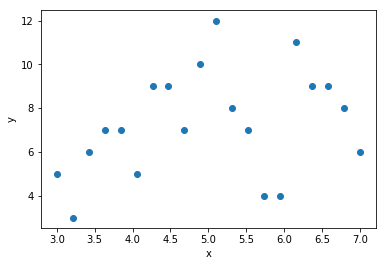

In [8]:
plt.scatter(data.x, data.y)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [9]:
# statsmodelsを使って最尤推定でパラメータを求める
import statsmodels.formula.api as smf

# scipy 1.0.0にはstats.chisqprobが無いため、statsmodels 0.8.0ではfitでエラーとなる。
# そのため、scipy.stats.chisqprobを再定義している。
# cf. https://github.com/statsmodels/statsmodels/issues/3931
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

result = smf.poisson('y ~ x', data=data).fit()
result.summary()

Optimization terminated successfully.
         Current function value: 2.250894
         Iterations 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                      y   No. Observations:                   20
Model:                        Poisson   Df Residuals:                       18
Method:                           MLE   Df Model:                            1
Date:                Sun, 04 Mar 2018   Pseudo R-squ.:                 0.01628
Time:                        16:03:07   Log-Likelihood:                -45.018
converged:                       True   LL-Null:                       -45.763
                                        LLR p-value:                    0.2222
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.5661      0.360      4.351      0.000       0.861       2.272
x              0.0833      0.068      1.219      0.223      -0.051       0.217
==============================================================================
"""

## 9.3 無情報事前分布

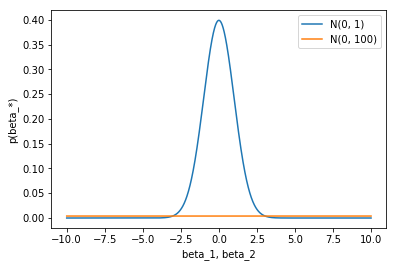

In [10]:
# N(0, 1)とN(0, 100)の確率密度を比較
from scipy.stats import norm

x = np.arange(-10.00, 10.01, 0.01)

plt.plot(x, [norm.pdf(x_i, 0, 1) for x_i in x], label='N(0, 1)')
plt.plot(x, [norm.pdf(x_i, 0, 100) for x_i in x], label='N(0, 100)')
plt.legend()
plt.xlabel('beta_1, beta_2')
plt.ylabel('p(beta_*)')
plt.show()

## 9.4 ベイズ統計モデルの事後分布の推定

In [11]:
# pip install pymc3
import pymc3

In [12]:
# np.float128ではエラーとなったのでfloat64に型変換
data['x'] = data['x'].astype(np.float64)
data['y'] = data['y'].astype(np.float64)

In [13]:
with pymc3.Model() as model:
    # 事前分布をN(0, 100)の正規分布で設定
    beta1 = pymc3.Normal('beta1', mu=0, sd=100)
    beta2 = pymc3.Normal('beta2', mu=0, sd=100)
    
    # 線形予測子θをβ1+β2xで設定
    theta = beta1 + beta2*data['x'].values
    
    # ログリンク関数(log(μ)=θ⇔μ=exp(θ))を設定し、ポアソン分布で推定する
    y = pymc3.Poisson('y', mu=np.exp(theta), observed=data['y'].values)

Multiprocess sampling (3 chains in 3 jobs)
HamiltonianMC: [beta2, beta1]
100%|██████████| 1600/1600 [00:05<00:00, 317.69it/s]
The acceptance probability does not match the target. It is 0.9496726092209469, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9614797690059621, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9581286554720173, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta1,1.559852,0.363690,0.008792,0.862994,2.262217,1500.0,0.999029
beta2,0.082643,0.069532,0.001646,-0.050683,0.214471,1500.0,0.999056


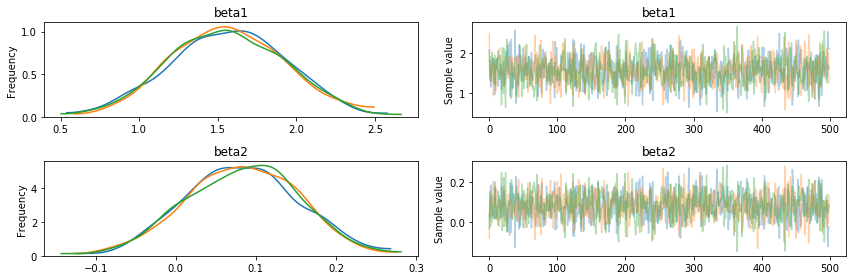

In [15]:
# ハミルトニアンモンテカルロ法
with model:
    # 101個目から3個置きでサンプルを取得するチェインを3つ作る
    trace = pymc3.sample(1500, step=pymc3.HamiltonianMC(), tune=100, njobs=3, random_seed=0)[::3]
    
_ = pymc3.traceplot(trace)

pymc3.summary(trace)

In [16]:
print('Trace type:', type(trace)) # Trace type: <class 'pymc3.backends.base.MultiTrace'>
print('Trace length:', len(trace)) # Trace length: 500
print('trace[0]:', trace[0]) # trace[0]: {'beta1': 2.0772965015391716, 'beta2': -0.02971672503615687}

Trace type: <class 'pymc3.backends.base.MultiTrace'>
Trace length: 500
trace[0]: {'beta1': 2.0772965015391716, 'beta2': -0.02971672503615687}


Multiprocess sampling (3 chains in 3 jobs)
CompoundStep
>Metropolis: [beta2]
>Metropolis: [beta1]
100%|██████████| 1600/1600 [00:01<00:00, 1216.67it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta1,1.425332,0.429842,0.041213,0.629598,2.347260,9.0,1.007059
beta2,0.109355,0.081587,0.007837,-0.054453,0.259157,9.0,1.007654


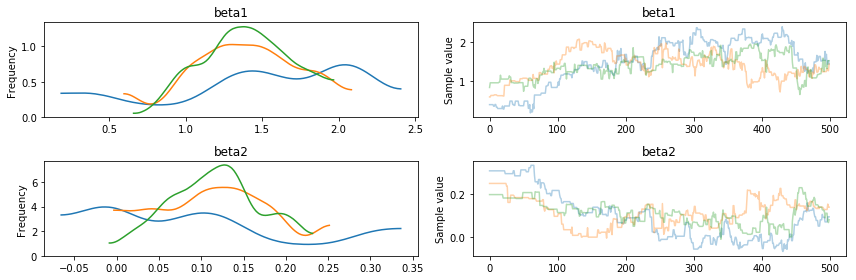

In [17]:
# メトロポリス法
with model:
    # 101個目から3個置きでサンプルを取得するチェインを3つ作る
    trace_Metropolis = pymc3.sample(1500, step=pymc3.Metropolis(), tune=100, njobs=3, random_seed=0)[::3]

_ = pymc3.traceplot(trace_Metropolis)

pymc3.summary(trace_Metropolis)

Multiprocess sampling (3 chains in 3 jobs)
NUTS: [beta2, beta1]
100%|██████████| 1600/1600 [00:06<00:00, 259.80it/s]
The acceptance probability does not match the target. It is 0.9490504292686058, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.937982501428317, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.946201094495367, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta1,1.572677,0.352272,0.011939,0.887621,2.241967,826.0,1.001525
beta2,0.080501,0.066583,0.002218,-0.041115,0.218631,818.0,1.000780


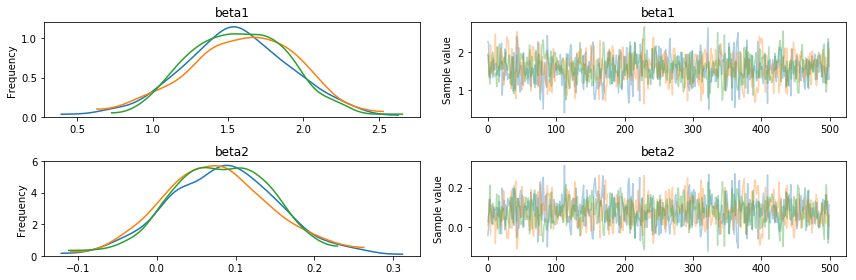

In [18]:
# NUTS(デフォルト)でサンプリング
with model:
    # 101個目から3個置きでサンプルを取得するチェインを3つ作る
    trace_NUTS = pymc3.sample(1500, step=pymc3.NUTS(), tune=100, njobs=3, random_seed=0)[::3]
    
_ = pymc3.traceplot(trace_NUTS)

pymc3.summary(trace_NUTS)

## 9.5 MCMCサンプルから事後分布を推定

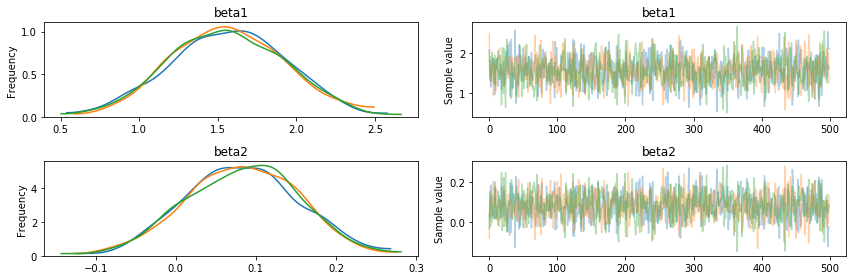

In [19]:
# ハミルトニアンモンテカルロ法のサンプリング過程を表示(再掲)
_ = pymc3.traceplot(trace)

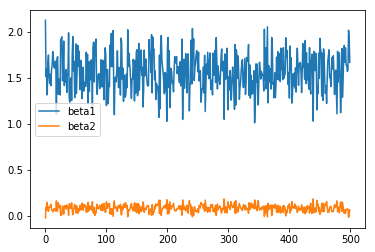

In [20]:
# 同時事後分布p(β1,β2|Y)のプロット
beta1_averages = np.zeros(len(trace), dtype=np.float64)
beta2_averages = np.zeros(len(trace), dtype=np.float64)

for i in trace.chains:
    # 各サンプル列のパラメータの平均値を計算
    beta1_averages += trace.get_values('beta1', chains=i) / trace.nchains
    beta2_averages += trace.get_values('beta2', chains=i) / trace.nchains

plt.plot(beta1_averages, label='beta1')
plt.plot(beta2_averages, label='beta2')
plt.legend()

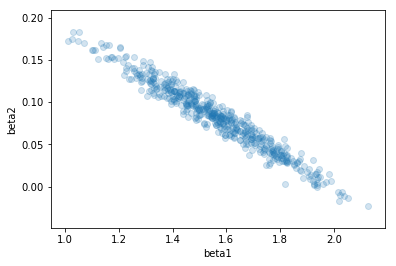

In [21]:
# 同時事後分布p(β1,β2|Y)を散布図でプロット
plt.scatter(beta1_averages, beta2_averages, alpha=0.2)
plt.xlabel('beta1')
plt.ylabel('beta2')

In [22]:
# ハミルトニアンモンテカルロ法の事後分布の統計量を表示(再掲)
pymc3.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta1,1.559852,0.363690,0.008792,0.862994,2.262217,1500.0,0.999029
beta2,0.082643,0.069532,0.001646,-0.050683,0.214471,1500.0,0.999056
